This will be used into getting the error of the FEM 1D Terazaghi, using the analytical as the reference point

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from matplotlib.animation import FuncAnimation 
from IPython.display import HTML

from scripts.1D_Terazaghi.1D_FEA_NumPy import Get_Terazaghi1D_Numpy

SyntaxError: invalid decimal literal (2802201844.py, line 9)

First lets plot the FEM model for terazaghi and also create a df for this data withiin time and depth. 

In [ ]:
H = 5
num = 100
nodes = num + 1
P = 100 # stress applied 
Tx = 60*60*24*365 # seconds to a year Please keeps this within days 
time_step = 100
dt = Tx / time_step
Cv = 2e-7 # m^2/s (coefficient of consolidation)
Mv = 5e-4 # 1/kPa  (or m^2/kN)

time_factor = (Cv * dt) / H**2

# n terms for analitical solution 
N_terms = 1000



In [ ]:

a = Get_Terazaghi1D_Numpy(H, num, P, Tx, time_step, Cv)

In [ ]:

def create_local(Cv, Z):
    he = np.diff(Z)
    if np.round(he[0:1]) == np.round(he[1:2]):
        he = he[0:1]
        me = np.array([[2,1], [1,2]])
        Me = (he / 6) * me
        ke = np.array([[1,-1], [-1,1]])
        Ke = (Cv / he) * ke
        return Me, Ke 
    else:
        print("ERROR - 'he' not uniform")

def create_global(Matrix, num_nodes):
    num_nodes = int(num_nodes)
    Global_M = np.zeros((num_nodes,num_nodes))
    n = np.arange(num_nodes)
    for i in range(np.max(n)):
        i = int(i)
        Global_M[i : (i+2), i : (i+2)] += Matrix
    return Global_M

def boundary_conditions(LF, nodes):
    p = 0
    LF[:,p] = 0
    LF[p,:] = 0
    LF[p,p] = 1
    return LF

def solve_timestep(GMe, B, U0, time_step, nodes):
    p = 0
    GMe[:,p] = 0
    GMe[p,:] = 0
    GMe[p,p] = 1

    U0[p] = 0
    linear_form = GMe @ U0
    loop = np.arange(int(time_step))

    for i in loop:
        if i == 0: 
            pass
        elif i == 1:
            data = U0
            linear_form = GMe @ data
            linear_form[p] = 0
            Un = np.linalg.solve(B, linear_form)
            Un = np.array([Un])
            data = data.reshape(-1, 1).T
            data = np.concatenate((data,Un), axis=0)
        elif i > 1:
            Un = data[(i-1):i,:nodes]
            Un = Un.T
            linear_form = GMe @ Un 
            Un1 = np.linalg.solve(B, linear_form)
            Un1 = Un1.reshape(-1, 1).T
            data = np.concatenate((data,Un1), axis=0)
    return data
        
def interval_plotting():
    fig = plt.figure()
    axis = plt.axes(xlim = (0,4),
        ylim = (-2,2))
    line, = axis.plot([],[], lw = 3)

    fig = plt.figure()
    
    axis = plt.axes(xlim = (0,4),
                ylim = (-2,2))
    line, = axis.plot([],[], lw = 3)

    def init():
        line.set_data([],[])
        return line,

    def animate(i):
        x = np.linspace(0, 4, 1000)
        y = np.sin(2 * np.pi * (x - 0.01 * i))
        line.set_data(x,y)
    return line,

# Setting up finite elements line and depths 
Z = -np.linspace(0, H, num = nodes)
U0 = P*np.ones(Z.shape, dtype=float)

# getting global matriccs and creating bilinear and linear form 
Me, Ke = create_local(Cv = Cv, Z=Z)
GMe, GKe = create_global(Me, nodes), create_global(Ke, nodes)
bilinear_form = (GMe) + (dt * GKe)

#apply boundary conditions and pore pressure solver 
B = boundary_conditions(bilinear_form, nodes)
data = solve_timestep(GMe, B, U0, time_step, nodes)

# Calculating local degree of consolidation
cdata = 1 - (data / P) 

fem_cdata = pd.DataFrame(cdata, columns = Z, index = np.arange(0, time_step))


In [ ]:
def terzaghi(H, Tx, time_step, nodes, Cv):
    Z = np.linspace(0, H, nodes)                 
    Cdata = np.zeros((time_step, nodes), dtype=float)
    T = np.linspace(0, Tx, time_step, dtype=float)

    for i in np.arange(nodes):
        z = Z[i]
        for j in np.arange(len(T)):
            t = T[j]
            S = 0.0
            for n in range(N_terms):
                m = (2 * n) + 1
                S += (1.0 / m) * np.sin((m * np.pi * z) / (2.0 * H)) * np.exp(-((m**2) * (np.pi**2) * Cv * t) / (4.0 * (H**2)))
            
            Cn = (4.0 / np.pi) * S
            Cdata[j, i] = Cn
    return Cdata

cdata = terzaghi(H, Tx, time_step, nodes, Cv)
cdata = 1 - cdata

# redefining due to plotting 
Z = -np.linspace(0, H, nodes)

Analytical_cdata = pd.DataFrame(cdata, columns = Z, index = np.arange(0, time_step))



Computing for Error 

Text(0.5, 1.0, 'Error between FEM and Analytical Solution')

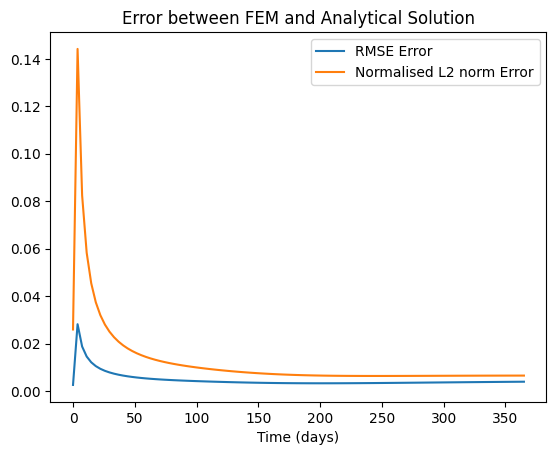

In [ ]:
# assumes that the t and z for both data is identical in which it is 
error = fem_cdata - Analytical_cdata


#RMSE error per time step 
RMSE = np.sqrt((error**2).mean(axis = 1))

# Normalised L2 norm error 
num = (error**2).sum(axis = 1)
den = (Analytical_cdata**2).sum(axis = 1)

E_L2 = np.sqrt(num / den) 
E_L2

time = np.linspace(0, (Tx/(60*60*24)), time_step)

plt.figure()
plt.plot(time, RMSE, label = "RMSE Error")
plt.plot(time, E_L2, label = "Normalised L2 norm Error")
plt.xlabel("Time (days)")
plt.legend()
plt.title("Error between FEM and Analytical Solution")

USE A HEAT MAP IT BETTER AT TELLING INFORMATION FOR THIS RATHER THAN A ANIMATION GRAPH WHICH CANT BE USED IN THE REPORT.

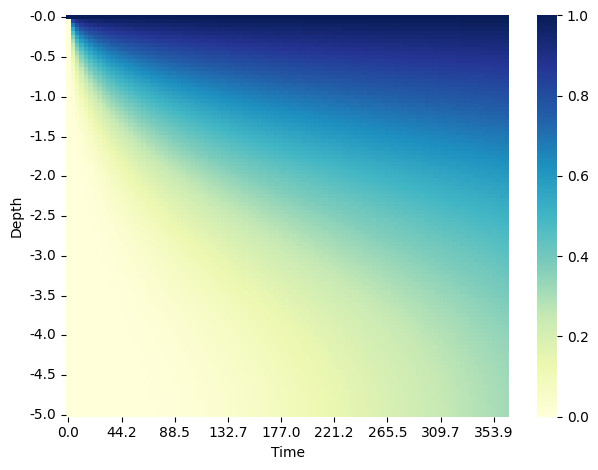

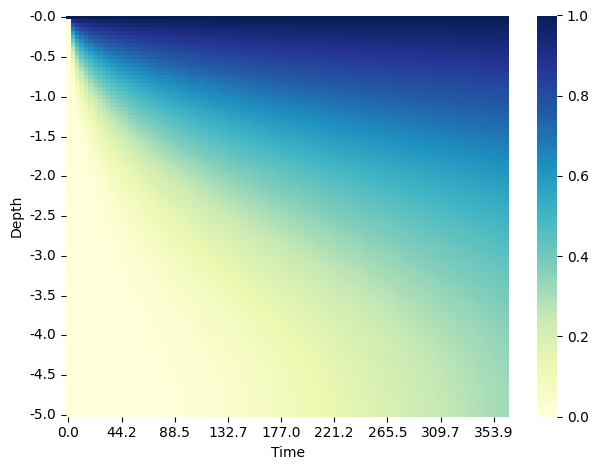

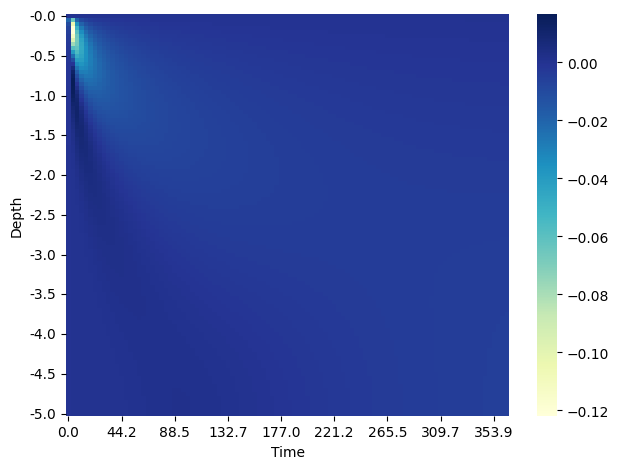

In [ ]:
time = time
depth = Z
fem_cdata

kx = max(1, len(time)//8)    # ~8 labels across, auto
ky = max(1, len(depth)//10)  # ~10 labels down, auto 

ax = sns.heatmap(fem_cdata.T, annot=False, cmap="YlGnBu", 
                 xticklabels=time, yticklabels=depth)

ax.set_xticks(np.arange(0, len(time), kx) + 0.5)
ax.set_xticklabels([f"{time[i]:.1f}" for i in range(0, len(time), kx)],
                   rotation=0)

ax.set_yticks(np.arange(0, len(depth), ky) + 0.5)
ax.set_yticklabels([f"{depth[i]:.1f}" for i in range(0, len(depth), ky)],
                   rotation=0)


ax.set_xlabel("Time")
ax.set_ylabel("Depth")
plt.tight_layout()
plt.show()



ax = sns.heatmap(Analytical_cdata.T, annot=False, cmap="YlGnBu", 
                 xticklabels=time, yticklabels=depth)

ax.set_xticks(np.arange(0, len(time), kx) + 0.5)
ax.set_xticklabels([f"{time[i]:.1f}" for i in range(0, len(time), kx)],
                   rotation=0)

ax.set_yticks(np.arange(0, len(depth), ky) + 0.5)
ax.set_yticklabels([f"{depth[i]:.1f}" for i in range(0, len(depth), ky)],
                   rotation=0)


ax.set_xlabel("Time")
ax.set_ylabel("Depth")
plt.tight_layout()
plt.show()


ax = sns.heatmap(error.T, annot=False, cmap="YlGnBu", 
                 xticklabels=time, yticklabels=depth)

ax.set_xticks(np.arange(0, len(time), kx) + 0.5)
ax.set_xticklabels([f"{time[i]:.1f}" for i in range(0, len(time), kx)],
                   rotation=0)

ax.set_yticks(np.arange(0, len(depth), ky) + 0.5)
ax.set_yticklabels([f"{depth[i]:.1f}" for i in range(0, len(depth), ky)],
                   rotation=0)


ax.set_xlabel("Time")
ax.set_ylabel("Depth")
plt.tight_layout()
plt.show()




